# Import library and data

In [1]:
import scipy.io
import numpy as np
import torch, os
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import seaborn as sns
import matplotlib.pyplot as plt
mat = scipy.io.loadmat('ex4data1.mat')
X = mat['X']
y = mat['y']
del mat

# Change output format

In [2]:
y_a = np.zeros((10,5000)).astype('int32')
y_temp = np.where(y==10,0,y)
for i in range(5000):
    y_a[y_temp[i],i] = 1
y_a = (np.r_[y_a[1:,:], y_a[0,:].reshape(1,-1)].T)

# Plot 20 images randomly

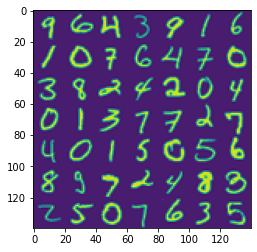

In [3]:
def img_out(X_array,loc):
    return X_array[loc,:].reshape((20,-1)).T
plot_sqr = 7
img = np.zeros((plot_sqr*20,plot_sqr*20))
img_index = np.random.randint(0,high=X.shape[0],size=plot_sqr**2)
img_tmp = [X[i,:].reshape((20,-1)).T for i in img_index]
for i in range(plot_sqr):
    img[:,i*20:(i+1)*20,] =(np.array(img_tmp[i*plot_sqr:(i+1)*plot_sqr]).reshape((-1,20)))
plt.imshow(img)

# Move dataset to dataloadert

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_a = torch.from_numpy(X.astype(np.float32)).to(device)
y_x = (torch.from_numpy(y_a.astype(np.float32))).to(device)

dataset = TensorDataset(X_a, y_x)

test_ratio = 0.2  # 20% data split into test dataset
n_sample,n_feature = X_a.shape
test_size = int(n_sample * test_ratio)
train_size = n_sample - test_size
train_ds, test_ds = random_split(dataset,[train_size, test_size])
train_dataloader = DataLoader(train_ds, batch_size=train_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=test_size)

# Create neural network class
shape of the NN 400,10 (hidden layer 1),10 (hidden layer 2), 10 (output layer)

In [5]:
class NumberNN(nn.Module):
    def __init__(self):
        super(NumberNN, self).__init__()
        layer1_out = 10
        layer2_out = 10
        self.layer1 = nn.Linear(400,layer1_out,bias=True)
        self.layer2 = nn.Linear(layer1_out,layer2_out,bias=True)
        self.output = nn.Linear(layer2_out,10,bias=True)

    def forward(self, x):
        z = torch.relu(self.layer1(x))
        z = torch.relu(self.layer2(z))
        z = torch.sigmoid(self.output(z))
        return z

# Load, Train, and Save

In [6]:
model = NumberNN().to(device)
if os.path.exists('NN_number_classification.pt'):
    model.load_state_dict(torch.load('NN_number_classification.pt',map_location=device))
    epoch_max = 100
    report = 10
    print('Load model from file')
else:
    epoch_max = 10000
    report = 500
loss = nn.BCELoss()
rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=rate,weight_decay=1e-3)
for i in range(epoch_max):
    for x_batch_train, y_batch_train in train_dataloader:
        z = model(x_batch_train)
        J = loss(z,y_batch_train)
        J.backward()
        optimizer.step()
        optimizer.zero_grad()
    if i % report  == 0:
        with torch.no_grad():
            acc = (1-(z.round()-y_batch_train).abs().mean().item())*100
            for x_batch_test, y_batch_test in test_dataloader:
                zx = model(x_batch_test)
                acc_test = (1-(zx-y_batch_test).abs().mean().item())*100
        print(f'Epoch {i}: Cost = {J.item():.4f}, train acc = {acc:.4f}%, test acc = {acc_test:.4f}%')

torch.save(model.state_dict(),'NN_number_classification.pt')

Load model from file
Epoch 0: Cost = 0.0412, train acc = 98.8975%, test acc = 96.9295%
Epoch 10: Cost = 0.0404, train acc = 98.9275%, test acc = 96.8934%
Epoch 20: Cost = 0.0400, train acc = 98.9475%, test acc = 96.8441%
Epoch 30: Cost = 0.0397, train acc = 98.9525%, test acc = 96.8026%
Epoch 40: Cost = 0.0395, train acc = 98.9550%, test acc = 96.7714%
Epoch 50: Cost = 0.0394, train acc = 98.9675%, test acc = 96.7504%
Epoch 60: Cost = 0.0393, train acc = 98.9800%, test acc = 96.7361%
Epoch 70: Cost = 0.0392, train acc = 98.9825%, test acc = 96.7215%
Epoch 80: Cost = 0.0391, train acc = 98.9750%, test acc = 96.7129%
Epoch 90: Cost = 0.0391, train acc = 98.9875%, test acc = 96.7058%


# Create a confusion matrix

In [7]:
with torch.no_grad():
    z = model(X_a).cpu().detach().numpy()
confusion_matrix = np.zeros((10,10),dtype=int)
z0 = np.argmax(z,axis=1)+1
z_val = np.where(z0==10,0,z0)
y0 = y.flatten()
y_val = np.where(y0==10,0,y0)
for i,val in enumerate(y_val):
    confusion_matrix[y_val[i],z_val[i]] +=1

# Plot the confusion matrix

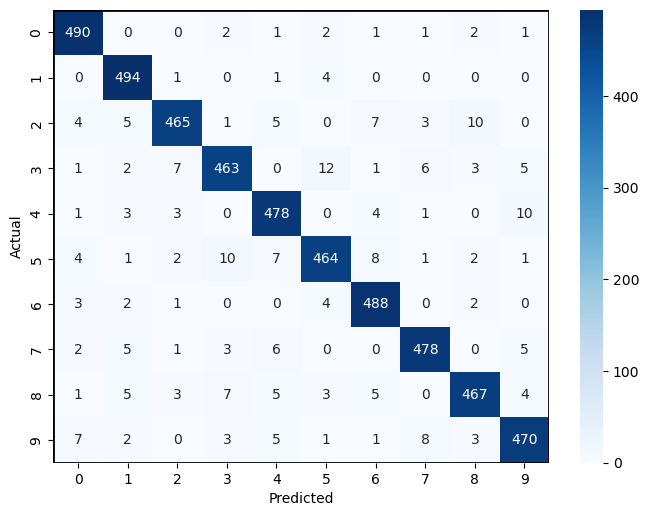

In [8]:
plt.figure(figsize=(8,6),dpi=100)
ax = sns.heatmap(confusion_matrix, annot=True,cmap='Blues', fmt='g')
ax.set(xlabel ='Predicted',ylabel='Actual')
ax.axhline(y=0, color='k',linewidth=2)
ax.axhline(y=10, color='k',linewidth=2)
ax.axvline(x=0, color='k',linewidth=2)
ax.axvline(x=10, color='k',linewidth=2)

# Create report of machine learning

In [9]:
print ("{:<8} {:<10} {:<10} {:<10}".format('Num','Precision','Recall','F1 Score'))
for i in range(10):
    precision = confusion_matrix[i,i] / confusion_matrix[i,:].sum()
    recall = confusion_matrix[i,i] / confusion_matrix[:,i].sum()
    f1 = 2*precision*recall/(precision+recall)
    print ("{:<8} {:<10} {:<10} {:<10}".format(i,round(precision,4),round(recall,4),round(f1,4)))

Num      Precision  Recall     F1 Score  
0        0.98       0.9552     0.9674    
1        0.988      0.9518     0.9696    
2        0.93       0.9627     0.9461    
3        0.926      0.9468     0.9363    
4        0.956      0.9409     0.9484    
5        0.928      0.9469     0.9374    
6        0.976      0.9476     0.9616    
7        0.956      0.9598     0.9579    
8        0.934      0.955      0.9444    
9        0.94       0.9476     0.9438    


In [16]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val,z_val))
print(classification_report(y_val,z_val))

[[490   0   0   2   1   2   1   1   2   1]
 [  0 494   1   0   1   4   0   0   0   0]
 [  4   5 465   1   5   0   7   3  10   0]
 [  1   2   7 463   0  12   1   6   3   5]
 [  1   3   3   0 478   0   4   1   0  10]
 [  4   1   2  10   7 464   8   1   2   1]
 [  3   2   1   0   0   4 488   0   2   0]
 [  2   5   1   3   6   0   0 478   0   5]
 [  1   5   3   7   5   3   5   0 467   4]
 [  7   2   0   3   5   1   1   8   3 470]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       500
           1       0.95      0.99      0.97       500
           2       0.96      0.93      0.95       500
           3       0.95      0.93      0.94       500
           4       0.94      0.96      0.95       500
           5       0.95      0.93      0.94       500
           6       0.95      0.98      0.96       500
           7       0.96      0.96      0.96       500
           8       0.96      0.93      0.94       500
           9       0.95     

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_a = torch.from_numpy(X.astype(np.float32)).to(device)
y_x = (torch.from_numpy(y_a.astype(np.float32))).to(device)

dataset = TensorDataset(X_a, y_x)

test_ratio = 0.2  # 20% data split into test dataset
n_sample,n_feature = X_a.shape
test_size = int(n_sample * test_ratio)
train_size = n_sample - test_size
train_ds, test_ds = random_split(dataset,[train_size, test_size])
train_dataloader = DataLoader(train_ds, batch_size=train_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=test_size)